This notebook will go over univariate time series forecasting methods like SARIMA and Exponential smoothing methods like the Holt-Winters method

Imports

In [248]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as datetime
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Processing dataframe

In [249]:
df = pd.read_csv('../data/Grouped_Walmart_Sales.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index("date")
df = df.sort_values('date')

First we can split our weekly sale data into subsets so we can perform cross validation on  models to compare performance

In [250]:
x_train, x_test = df[:104][['weekly_sales']], df[104:][['weekly_sales']]

Firstly we can try SARIMAX (Seasonal Autoregressive Integrated moving average with exogenous variables). (Test without exogenous variable to see if the model can model the jump in sales during holidays well)

First step to use SARIMAX is to select the correct parameters which is the autocorrelation parameter from the PACF (partial auto correlation function) plot and the moving average parameter from the ACF (auto correlation function) plot

The ACF plot shows the correlation between y_t and y_(t-k) at lag k and helps identify the q (or MA) term.
The PACF plot shows the correlation between y_t and y_(t-k) at lag k after removing effects of lag 1 to lag k-1 and will help identify p (or AR) term for our SARIMA Model

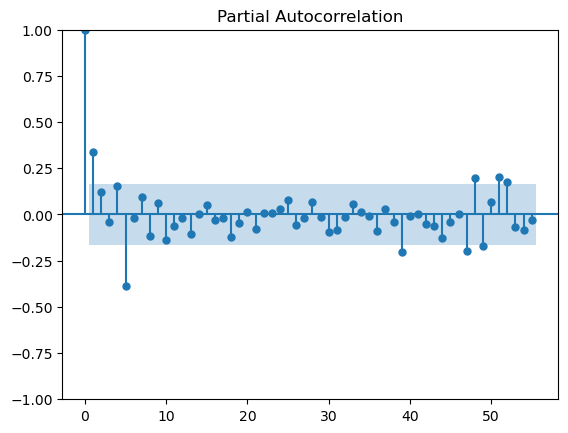

In [251]:
# PLOTTING PACF
plot_pacf(df['weekly_sales'], lags=55)
plt.show()

To read a PACF we must look at the lag where pacf drops close to zero so in this case we can use p=1 for order and P=1 for the seasonal order since there is a spike at 52 meaning there is correlation between the last year data and the current year

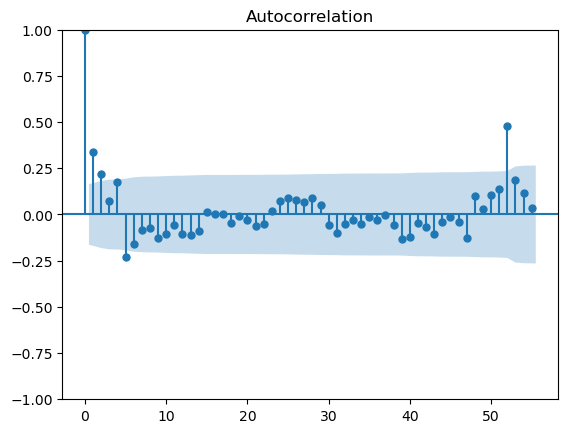

In [252]:
# PLOTTING ACF
plot_acf(df['weekly_sales'], lags=55)
plt.show()

Similarly to PACF we have q=1 for the order and we can use Q=1 because there is a correlation from the past years (or 1 season which is 52 weeks)

In [253]:
# SARIMAX order(p,d,q) parameter handles the non-repeating patterns in data, 
# (trends, noise, etc.). in this case we have p=1, d=0, q=1
# (we get p and q values from the pacf and acf plots and d = 0 because ad-fuller test)

# SARIMAX seasonal_order(p,d,q,s) handles the repeating cycles(weekly and yearly patterns)
# we have p=1, d=1, q=1 (p, q = 1 because data depends on previous season)
model = SARIMAX(df[['weekly_sales']], order=(1,0,1), seasonal_order=(1,1,1,52))
results = model.fit()
forecast = results.get_forecast(steps=52)

/Users/eric/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/eric/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/eric/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05041D+01    |proj g|=  2.56599D+00


 This problem is unconstrained.



At iterate    5    f=  1.02043D+01    |proj g|=  6.02467D+00

At iterate   10    f=  1.01344D+01    |proj g|=  2.84591D-03

At iterate   15    f=  1.01300D+01    |proj g|=  4.77310D-01

At iterate   20    f=  1.01110D+01    |proj g|=  3.65037D-02

At iterate   25    f=  1.01101D+01    |proj g|=  1.74359D-03

At iterate   30    f=  1.01094D+01    |proj g|=  3.95285D-02

At iterate   35    f=  1.01086D+01    |proj g|=  3.60420D-03

At iterate   40    f=  1.01082D+01    |proj g|=  8.12639D-03

At iterate   45    f=  1.01080D+01    |proj g|=  9.49604D-03

At iterate   50    f=  1.01080D+01    |proj g|=  8.31483D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/eric/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


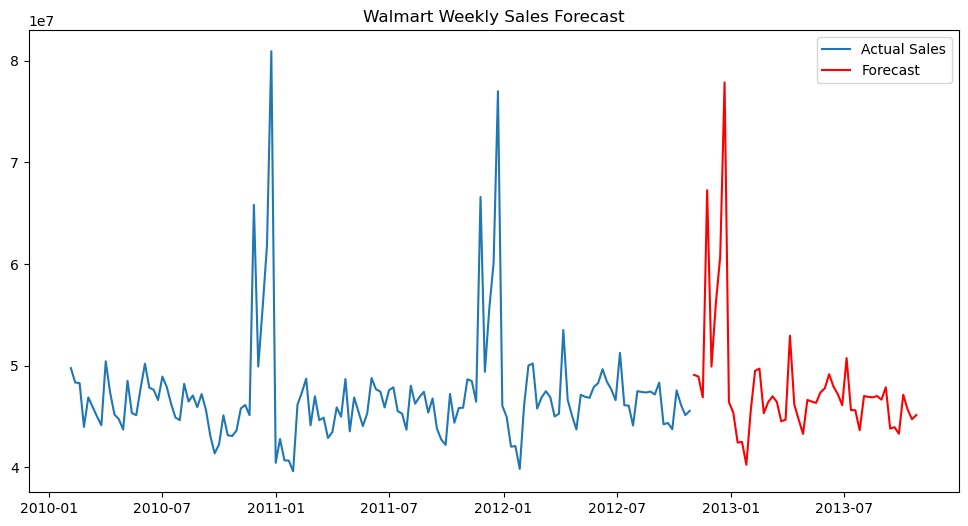

In [254]:
plt.figure(figsize=(12, 6))
plt.plot(df['weekly_sales'], label='Actual Sales')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.legend()
plt.title('Walmart Weekly Sales Forecast')
plt.show()

Now we can see that the SARIMA model works but need to use the train and test set to measure performance

In [255]:
model = SARIMAX(x_train, order=(1,0,1), seasonal_order=(1,1,1,52))
results = model.fit()
sarima_forecast = results.get_forecast(steps=39)

/Users/eric/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/eric/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/eric/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30026D+00    |proj g|=  2.71702D+00

At iterate    5    f=  7.99939D+00    |proj g|=  6.01641D+00

At iterate   10    f=  7.94884D+00    |proj g|=  3.41833D-03

At iterate   15    f=  7.94872D+00    |proj g|=  5.58373D-02

At iterate   20    f=  7.93997D+00    |proj g|=  4.69889D-01

At iterate   25    f=  7.92970D+00    |proj g|=  7.36311D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     46      1     0     0   6.140D-03   7.929D+00
  F =   7.9294564736740183     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


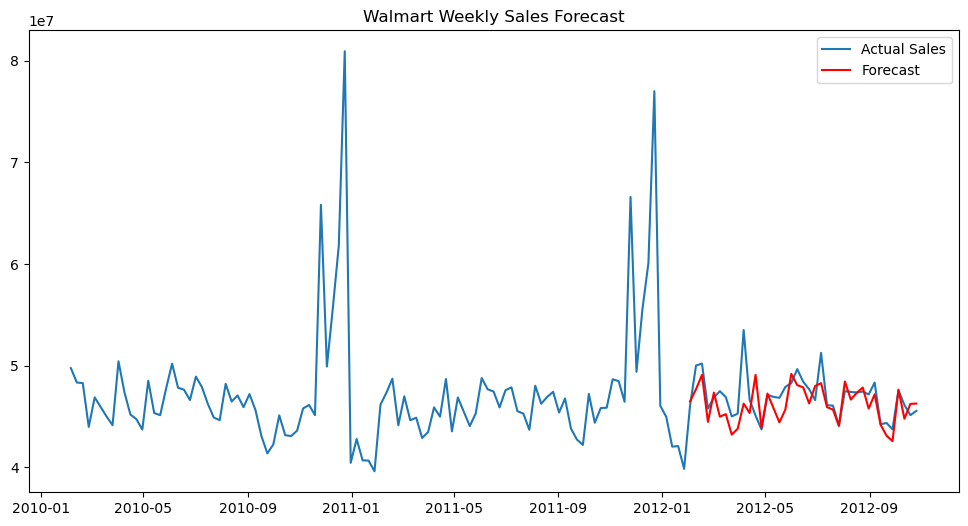

In [256]:
plt.figure(figsize=(12, 6))
plt.plot(df['weekly_sales'], label='Actual Sales')
plt.plot(sarima_forecast.predicted_mean, label='Forecast', color='red')
plt.legend()
plt.title('Walmart Weekly Sales Forecast')
plt.show()

Now to evaluate model performance, since we are going to compare it to other models we will use MAPE (Mean Absolute Percentage Error)

In [257]:
x_test = np.squeeze(np.array(x_test))
def calculate_mape(x_test, forecast):
    mape = 100 * np.mean(np.abs((x_test - forecast) / x_test))
    return mape
print(calculate_mape(x_test, sarima_forecast.predicted_mean))

2.756929353862353


Now we have a MAPE of around 2.76 so we will try using the Holt-Winters exponential smoothing method to forecast and compare MAPE Scores

In [258]:
model = ExponentialSmoothing(x_train, trend='add', seasonal='add', seasonal_periods=52)

/Users/eric/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [259]:
results = model.fit()
holtwinters_forecast = results.forecast(len(x_test))

/Users/eric/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


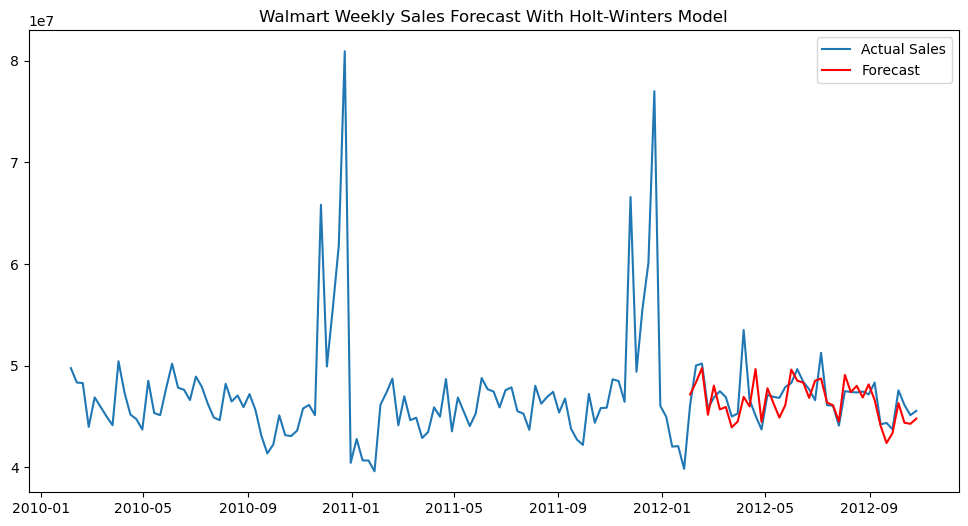

In [260]:
plt.figure(figsize=(12, 6))
plt.plot(df['weekly_sales'], label='Actual Sales')
plt.plot(holtwinters_forecast, label='Forecast', color='red')
plt.legend()
plt.title('Walmart Weekly Sales Forecast With Holt-Winters Model')
plt.show()

In [261]:
print(calculate_mape(x_test, holtwinters_forecast))

2.5971453331829606


We observe that holt winters model has a lower mape than the SARIMA model so we can also try to optimize the parameters when fitting the model to try and obtain the lowest mape score

In [262]:
def optimize_parameters(training_data, test_data):
    best_mape = float('inf')
    best_params = None
    best_forecast = None
    
    for alpha in np.arange(0.1, 1, 0.1):
        for beta in np.arange(0.1, 1, 0.1):
            for gamma in np.arange(0.1, 1, 0.1):
                model = ExponentialSmoothing(training_data,
                                           trend='add',
                                           seasonal='add',
                                           seasonal_periods=52)
                results = model.fit(smoothing_level=alpha,
                                  smoothing_trend=beta,
                                  smoothing_seasonal=gamma)
                forecast = results.forecast(len(test_data))
                    
                mape = calculate_mape(test_data, forecast)
                    
                if mape < best_mape:
                    best_mape = mape
                    best_params = (alpha, beta, gamma)
                    best_forecast = forecast
    return best_params, best_mape, best_forecast

best_params, best_mape, best_forecast = optimize_parameters(x_train, x_test)

/Users/eric/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/eric/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/eric/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/eric/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/eric/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_date

Best MAPE: 2.3358635201056224
Best parameters: (0.1, 0.7000000000000001, 0.6000000000000001)


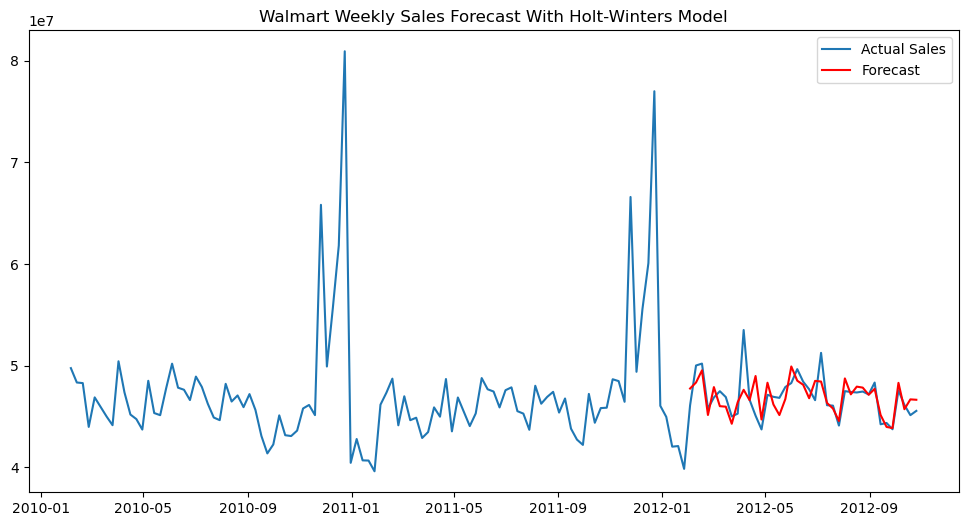

In [263]:
print('Best MAPE:', best_mape)
print('Best parameters:' , best_params)
plt.figure(figsize=(12, 6))
plt.plot(df['weekly_sales'], label='Actual Sales')
plt.plot(best_forecast, label='Forecast', color='red')
plt.legend()
plt.title('Walmart Weekly Sales Forecast With Holt-Winters Model')
plt.show()

After we can see our gridsearch on parameters improved our forecast by around .18 percent and overall we can see the holt-winters model performed better than the SARIMA model